## 데이터분석

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from tensorflow import keras
from scipy.interpolate import interp1d
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import backend as K
import pickle
from sklearn.model_selection import train_test_split
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 한글 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

데이터 load, 시트간 merge

In [2]:
def load():
        # new_data 들어오면 기존 df 에 합치면 됨
        data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='야드크레이인_작업이력')
        scd_data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='반출입_예정컨테이너')
        cbd_data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='장치장_전')
        cad_data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='장치장_후')
        quay_work_data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='본선크레인_작업이력')

        # data, container_before_data, container_after_data merge
        ycb_common_values = data['컨테이너번호'].isin(cad_data['컨테이너번호']).sum() # 6103개
        yard_con_common_df = pd.merge(data, cad_data, on='컨테이너번호')
        return yard_con_common_df
yard_con_common_df = load()


데이터 전처리(날짜 - datetime, 문자열 - 숫자)

In [3]:
def preprocessing(common_df):
        # 데이터 전처리
        common_df['작업코드'] = common_df['작업코드'].replace({'VU': 1, 'VL': 2, 'GR': 3, 'GD': 4, 'TM':5,'TS':6})
        common_df['장비번호'] = common_df['장비번호'].replace({'Y02': 1})
        common_df['풀(F)공(M)'] = common_df['풀(F)공(M)'].replace({'M':1, 'F':2})
        common_df['수출/수입'] = common_df['수출/수입'].replace({'X':1,'I':2,'S':3,'M':4})
        
        # 외부트럭에 1 넣기
        common_df['야드트럭(번호)'] = common_df['야드트럭(번호)'].fillna(1)
    
        # 시간 타입 통합
        common_df['작업생성시간'] = pd.to_datetime(common_df['작업생성시간'], format='%Y%m%d%H%M%S')
        common_df['작업완료시간'] = pd.to_datetime(common_df['작업완료시간'], format='%Y%m%d%H%M%S')
        #print('작업생성시간',common_df['작업생성시간'].dtype)
        #print('작업완료시간',common_df['작업완료시간'].dtype)
        common_df['작업+대기시간'] = common_df['작업완료시간'] -common_df['작업생성시간']
        # common_df = common_df[-200:]

        # 작업+대기차량 구하기
        common_df['작업+대기차량'] = 0
        # 행 인덱스를 역순으로 순회
        for i in range(len(common_df) - 1, -1, -1):
            # i번째 행의 작업생성시간
            creation_time = common_df.loc[i, '작업생성시간']
            # i번째 행보다 앞에 있는 행들 중에서 작업완료시간이 아직 지나지 않은 것들의 수를 계산
            count = 0
            for j in range(i - 1, -1, -1):
                if common_df.loc[j, '작업완료시간'] > creation_time:
                    count += 1
            
            # 계산한 수를 i번째 행의 '대기차량' 열에 저장
            common_df.loc[i, '작업+대기차량'] = count
        print(common_df[['작업+대기시간', '작업+대기차량']])

        # 작업+대기시간을 초로 변환
        common_df['작업+대기시간'] = common_df['작업+대기시간'].dt.total_seconds() /60.0
        common_df['풀(F)공(M)'] = common_df['풀(F)공(M)'].astype('int64')
        common_df = common_df.dropna(subset=['작업+대기시간'])
        common_df_complete = common_df
        common_df_complete.sort_values('작업생성시간', inplace=True)
        #print(common_df_complete[['작업생성시간','작업+대기시간']])


        common_df_complete = common_df_complete[['작업생성시간','작업+대기시간', '작업코드', '장비번호', '풀(F)공(M)', '수출/수입', '컨테이너(사이즈 코드)', '작업+대기차량']]
        common_df_complete['입차시간'] = common_df_complete['작업생성시간']
        #print(common_df_complete['작업+대기시간'])
        grouped_df = common_df_complete.groupby(pd.Grouper(key='작업생성시간', freq='5min')).mean()
        #print('grouped_df',grouped_df['작업+대기시간'])
        grouped_df['입차시간'] = grouped_df['입차시간'].astype('int64') // 10**9
        return grouped_df, common_df
grouped_df, common_df = preprocessing(yard_con_common_df)


             작업+대기시간  작업+대기차량
0    0 days 00:07:13        0
1    0 days 00:06:21        1
2    0 days 00:09:29        2
3    0 days 00:04:43        3
4    0 days 00:05:00        0
...              ...      ...
6098 0 days 00:20:39      139
6099 0 days 00:05:00       30
6100 0 days 00:05:00       26
6101 0 days 00:21:38      144
6102 0 days 00:05:00       26

[6103 rows x 2 columns]


C:\Users\SW\AppData\Local\Temp\ipykernel_7452\1394065981.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_df_complete.sort_values('작업생성시간', inplace=True)
C:\Users\SW\AppData\Local\Temp\ipykernel_7452\1394065981.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_df_complete['입차시간'] = common_df_complete['작업생성시간']


데이터 상관관계 분석

(2000, 42)
(4101, 42)


d:\김형찬\P6_disabled\P6_EmpCont\venv\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
d:\김형찬\P6_disabled\P6_EmpCont\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


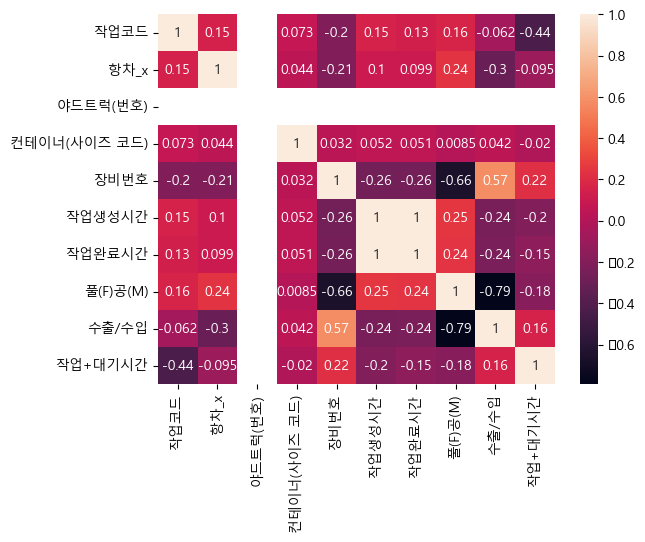

In [4]:
# data, quay merge
common_df_truck_in = common_df[common_df['야드트럭(번호)'] != 1]
print(common_df_truck_in.shape)
common_df_truck_out = common_df[common_df['야드트럭(번호)'] == 1]
print(common_df_truck_out.shape)
correlation_matrix = common_df_truck_out[['작업코드','항차_x','야드트럭(번호)','컨테이너(사이즈 코드)','장비번호', '작업생성시간','작업완료시간', '풀(F)공(M)', '수출/수입','작업+대기시간']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

LSTM 예측 모델 생성

In [5]:
def make_model(grouped_df):
    lookback = 30

    # 데이터 전처리
    X_data = grouped_df[['입차시간','작업+대기시간', '작업코드', '풀(F)공(M)','수출/수입','장비번호', '컨테이너(사이즈 코드)', '작업+대기차량']]
    y_data = grouped_df['작업+대기시간'].values

    X, y = [], []
    for i in range(grouped_df.shape[0] - lookback):
        X.append(X_data[i:i+lookback].values)
        y.append(y_data[i+lookback])
    X = np.array(X)
    y = np.array(y)

    # 시계열이라 데이터를 랜덤하게 분할하지 않고 시간대에 따라 분할
    train_size = int(len(X) * 0.8)

    # 시간 순서를 유지하면서 데이터 분할
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    print(X_train.shape)
    # 데이터 정규화
    scaler = MinMaxScaler()
    X_train_scaled = np.zeros_like(X_train)
    X_test_scaled = np.zeros_like(X_test)

    for i in range(X_train.shape[2]):
        X_train_scaled[:, :, i] = scaler.fit_transform(X_train[:, :, i])
        X_test_scaled[:, :, i] = scaler.transform(X_test[:, :, i])

    # y_train, y_test 스케일링
    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

    # LSTM 모델 구성
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=64, input_shape=(lookback, X_train.shape[-1])))
    model.add(keras.layers.Dense(units=64, activation='relu'))
    model.add(keras.layers.Dense(units=32, activation='relu'))
    model.add(keras.layers.Dense(units=1))

    # 모델 컴파일
    model.compile(loss='mean_squared_error', optimizer='adam')

    # 모델 학습
    model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32)

    # 모델 예측
    y_train_pred_scaled = model.predict(X_train_scaled)
    y_test_pred_scaled = model.predict(X_test_scaled)

    # 예측값을 원래의 스케일로 되돌리기
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

    # 원래의 스케일로 되돌린 실제값
    y_train_real = scaler_y.inverse_transform(y_train_scaled)
    y_test_real = scaler_y.inverse_transform(y_test_scaled)

    time_index = 0
    # '입차시간' 데이터 추출
    X_train_time = X_train[:, -1:, time_index].reshape(-1)
    X_test_time = X_test[:, -1:, time_index].reshape(-1)
    # '입차시간' 데이터 원래대로 되돌리기
    X_train_time_original = pd.to_datetime(X_train_time * 10**9)
    X_test_time_original = pd.to_datetime(X_test_time * 10**9)

    combined_time = np.concatenate((X_test_time_original, X_train_time_original), axis=0)
    combined_pred = np.concatenate((y_test_pred, y_train_pred), axis=0)
    combined_real = np.concatenate((y_test_real, y_train_real), axis=0)
    # datetime 형식을 리스트로 바꾸면 유닉스타임 스탬프로 변경돼서 다른 방법 써야 함
    # time = combined_time.tolist()
    datetime_list = pd.to_datetime(combined_time.tolist(), unit='ns')
    actual_values = combined_real.tolist()
    predict_values = combined_pred.tolist()
    
    return datetime_list, actual_values, predict_values, y_test_pred, y_train_pred, y_test_real, y_train_real
datetime_list, actual_values, predict_values, y_test_pred, y_train_pred, y_test_real, y_train_real = make_model(grouped_df)

(104, 30, 8)
Epoch 1/100
4/4 [==============================] - 2s 8ms/step - loss: 0.0803
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0376
Epoch 3/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0376
Epoch 4/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0357
Epoch 5/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0328
Epoch 6/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0327
Epoch 7/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0310
Epoch 8/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0308
Epoch 9/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0300
Epoch 10/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0293
Epoch 11/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0290
Epoch 12/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0286
Epoch 13/100
4/4 [==============================

예측값, 실제값 그래프 생성

그래프를 'lstm_graph.png' 파일로 저장했습니다.


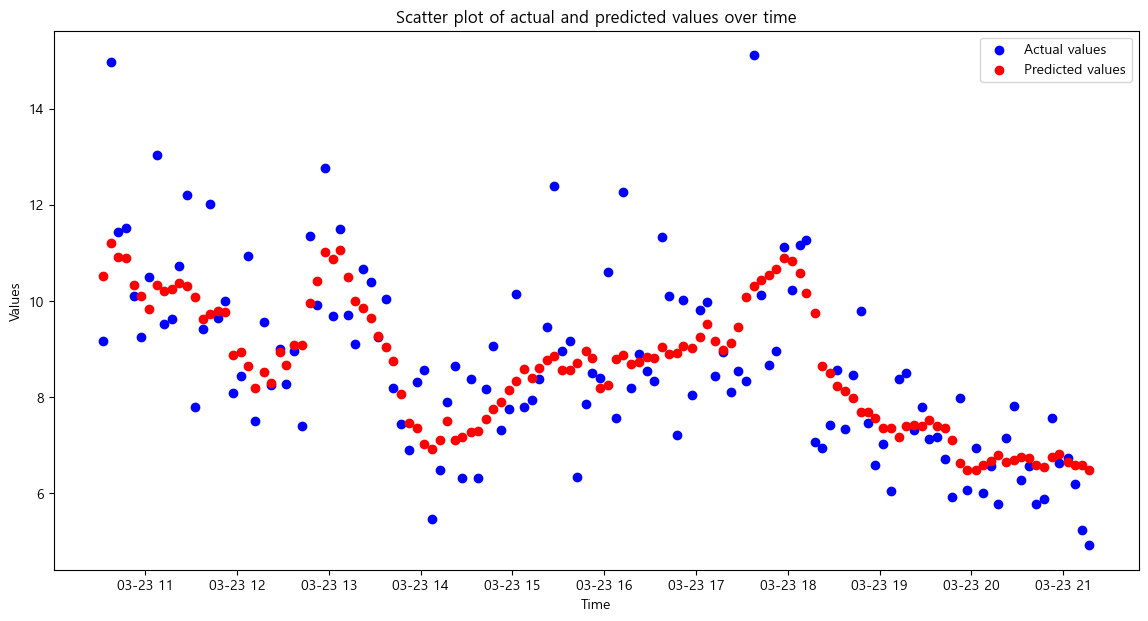

In [6]:
def make_graph(datetime_list, actual_values, predict_values):
# 그래프의 크기 설정
    plt.figure(figsize=(14, 7))
    plt.scatter(datetime_list, actual_values, color='blue', label='Actual values')
    plt.scatter(datetime_list, predict_values, color='red', label='Predicted values')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Scatter plot of actual and predicted values over time')
    plt.legend()
    graph_image_filename = "lstm_graph.png"
    plt.savefig(graph_image_filename)
    print(f"그래프를 '{graph_image_filename}' 파일로 저장했습니다.")
    plt.show()
make_graph(datetime_list, actual_values, predict_values)

예측 결과 평가

In [7]:
def valid(y_test_pred, y_train_pred, y_test_real, y_train_real):
# Mean Absolute Error (MAE)
    mae_train = mean_absolute_error(y_train_real, y_train_pred)
    mae_test = mean_absolute_error(y_test_real, y_test_pred)

    print(f'Train MAE: {mae_train}, Test MAE: {mae_test}')

    # Mean Squared Error (MSE)
    mse_train = mean_squared_error(y_train_real, y_train_pred)
    mse_test = mean_squared_error(y_test_real, y_test_pred)

    print(f'Train MSE: {mse_train}, Test MSE: {mse_test}')

    # Root Mean Squared Error (RMSE)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    print(f'Train RMSE: {rmse_train}, Test RMSE: {rmse_test}')

    # R^2 Score
    r2_train = r2_score(y_train_real, y_train_pred)
    r2_test = r2_score(y_test_real, y_test_pred)

    print(f'Train R^2: {r2_train}, Test R^2: {r2_test}')
valid(y_test_pred, y_train_pred, y_test_real, y_train_real)

Train MAE: 1.0333753771606173, Test MAE: 0.6686029493159418
Train MSE: 1.8150934769599587, Test MSE: 0.6387612116257888
Train RMSE: 1.3472540506377997, Test RMSE: 0.7992253822457022
Train R^2: 0.43072415920788165, Test R^2: 0.23512287388724862
